<a href="https://colab.research.google.com/github/vikrantmehta123/dl-for-coders-workbook/blob/main/Fastbook_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing ResNet

In this notebook, I have tried to implement the 14th chapter of FastAI's Deep Learning for Coders, in which I implement the residual neural networks.

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from fastbook import *

## Getting Data

We will define a function that fetches data from the Imagenette dataset, and it applies the transforms that we have discussed before.

In [3]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label,
        item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize), Normalize.from_stats(*imagenet_stats)]
    ).dataloaders(path, bs=128)

In [4]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

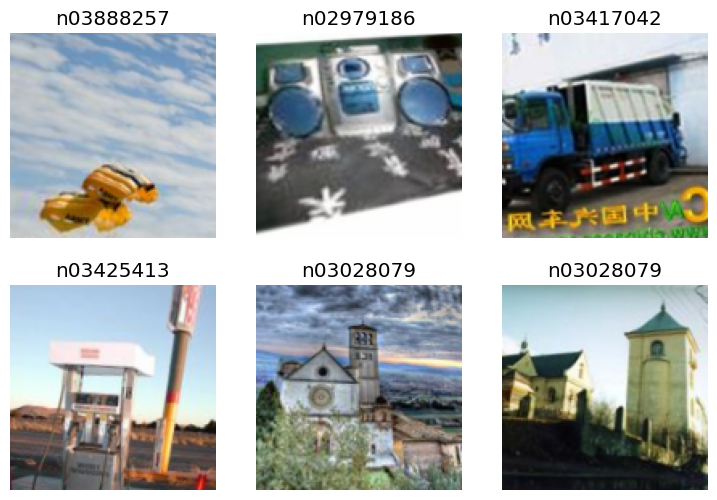

In [5]:
dls.show_batch(max_n=6)

## Why Do We Need a Better Architecture?

1. For MNIST, the image size was small. For large images, we would need a much deeper network to make the output conform to the number of classes.
2. If we use the MNIST like approach from the previous notebook, then the model cannot be used on images of any other size.

If you don't want to shrink the output in each layer, like we did with MNIST, you could flatten out the convolution output into a tensor and have a feedforward network there. But this requires too much memory due to flattening.


### Fully Convolutional Networks

You introduce pooling layer at the end that solves this last problem of too many parameters. This is not the same as MaxPooling or AvgPooling that you do that takes the max of a four-pixel window when applying convolutions.

Consider the following architecture as an example:

```python
def block(ni, nf):
    return ConvLayer(ni, nf, stride=2)

def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))
```

`ConvLayer` is a Fastai wrapper around `Conv2d`- it combines Batch Normalization, activation, etc.

But focus on the layer before the AdaptiveAvgPool2d. The output of that layer is of shape (128, 256, 7, 7). That is to say, that for each of the 128 samples in the batch, we have 256 feature maps of shape $7 \times 7$. What `AdaptiveAvgPool2d(1)` would do is that for each of the feature maps, it would take an average. In other words, it's saying that we can take average of the information captured by these feature maps. So we get the dimensions as (128, 256, 1, 1), which we can flatten into (128, 256) and connect to a linear output.

**Note:** `nn.AdaptiveAvgPool2d` averages a grid of activations into whatever sized destination you require (although we nearly always use a size of 1).



**IMPORTANT:**

Think about what this architecture is saying. Let's go back to the digit classification task. Let's say one of these feature maps corresponds to detecting edge in the top left. Another one corresponds to detecting an edge on top right. Their feature maps will have activations corresponding to what they have seen in the image. If you take an average of these activations, you basically are throwing away what they have learnt!

FCNs work incredibly well but only in cases where the objects don't have a particular orientation or size, such as natural images. For such images, it might make sense to average the activations captured by the feature maps.

In [6]:
def block(ni, nf):
    return ConvLayer(ni, nf, stride=2)

def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

We can define a learner and load it with this model.

In [7]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0003981071640737355)

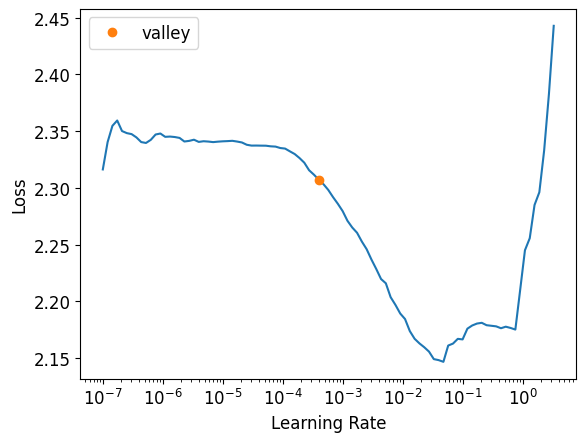

In [8]:
learn.lr_find()

**Pro Tip:** 3e-3 is often a good learning rate for CNNs.

In [9]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.879678,1.799931,0.420637,00:25
1,1.555366,1.635334,0.465987,00:27
2,1.299322,1.629033,0.518726,00:28
3,1.144237,1.144569,0.633631,00:29
4,1.049613,1.068934,0.659618,00:30


The model does okay, but not great. We barely achieve an accuracy of 70%. We can decide that we need to train a deeper model. But it so happens that training a deeper model is no help in this case! In fact, you get poorer performance by using deeper model!

Think about the interpretation of this:

If you start with a 20-layer neural network that is trained well, and add another 36 layers that do nothing at all (for instance, they could be linear layers with a single weight equal to 1, and bias equal to 0). The result will be a 56-layer network that does exactly the same thing as the 20-layer network, proving that there are always deep networks that should be at least as good as any shallow network. But for some reason, SGD does not seem able to find them.

## Skip Connections

[YouTube Tutorial](https://youtu.be/Q1JCrG1bJ-A?si=NpdhC9EMeQM8clNE) on what Residual connections do and the intuition behind it. It's one of the better resources to understand skip connections.

But the ideas behind ResNet's implementation are as follows:
1. We define blocks of layers, instead of defining each layer. This allows us to be flexible in terms of number of layers. We define the block and how two blocks are connected.
2. Within blocks we have two types of connections:
    - One that is regular CNN like
    - One that skips the intermediate layers of the block.
3. When we connect the two blocks, we want a simple function such that it allows gradients to pass through easily when doing backgpropagation.

The idea is that if the intermediate layers don't have anything to contribute, then we have the *skip connection* that we are passing as is, which means that the model will perform at least as good as the shallow model.

The job of intermediate layers of a block is to figure out what additional information it can contribute- since the old `x` is going to be passed as is to the next layer by the skip connection.

Further, during backpropagation, the gradients can flow back easily through these skip connections allowing better weight updates and less dead neurons.

**Note:** Refer to the video for reinforcing the intuition of ResNets.

Let's define the *block* for this skip connections.

In [10]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero)) # Last batch normalization layer is initialized to zero. Helps in ResNet training. act_cls=None, removes ReLU

class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None) # Apply 1D convolution if the channels don't match
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # Apply Average pooling to match dimensions of feature maps

    def forward(self, x):
        # The thinking behind this is that the whole ResNet block is like a layer, and you want your activation to be after your layer.
        return F.relu(self.convs(x) + self.idconv(self.pool(x))) # apply ReLU after the entire block

The more simpler code for the forward pass is given in PyTorch, which I am listing below for reference:

In [11]:
def forward(self, x: Tensor) -> Tensor:
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

# Downsampling is nothing but resizing so that the initial `x` matches with the `x` after convolving
    if self.downsample is not None:
        identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

In [12]:
def block(ni,nf):
    return ResBlock(ni, nf, stride=2)
learn = get_learner(get_model())

In [13]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.945083,1.842697,0.375032,00:30
1,1.652199,1.698090,0.453503,00:31
2,1.372818,1.293802,0.582675,00:27
3,1.142025,1.044546,0.673631,00:28
4,1.002121,1.001223,0.687643,00:29


The whole idea of ResNets and skip connections is that it allows us to train deeper neural networks. So we should train a deeper network.

In [14]:
def block(in_channels, out_channels):
    return nn.Sequential(
        ResBlock(in_channels, out_channels, stride=2),
        ResBlock(out_channels, out_channels)
        )

In [15]:
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.953352,1.886648,0.339108,00:29
1,1.633967,1.498690,0.512611,00:31
2,1.345409,1.181562,0.615796,00:29
3,1.113060,1.019657,0.681529,00:32
4,0.969266,0.955500,0.697325,00:29


Just an interesting paragraph from text:

*It is interesting to note that in both cases the starting points for the breakthroughs were experimental observations: observations about what layers actually learn, in the case of Zeiler and Fergus, and observations about which kinds of networks can be trained, in the case of the ResNet authors. This ability to design and analyze thoughtful experiments, or even just to see an unexpected result, say "Hmmm, that's interesting," and then, most importantly, set about figuring out what on earth is going on, with great tenacity, is at the heart of many scientific discoveries. Deep learning is not like pure mathematics. It is a heavily experimental field, so it's important to be a strong practitioner, not just a theoretician.*

Using ResNets gives a more smoother loss function, which makes training easier, and we can experiment with faster learning rates which can increase the speed of training.

## Modern ResNets

Modern ResNets have a couple of more tricks up their sleeve. Firstly, they don't directly start by skip connections. In the initial layers, there are some convolutional layers followed by a MaxPooling layer. These initial layers are called *step* of the network. Why do we have these initial convolutional layers before skip connections?

**The reason that we have a stem of plain convolutional layers, instead of ResNet blocks, is based on a very important insight about all deep convolutional neural networks: the vast majority of the computation occurs in the early layers. Therefore, we should keep the early layers as fast and simple as possible.**

This insight is specifically about deep, fully convolutional neural networks.

A ResNet block takes more computation than a plain convolutional block, since (in the stride-2 case) a ResNet block has three convolutions and a pooling layer. That's why we want to have plain convolutions to start off our ResNet.

Modern ResNet uses four groups of ResNet Blocks with (64, 128, 256, 512) filters.

In [19]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride=2 if i==0 else 1)
        for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [17]:
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))

    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

Let's train a simpler version which is ResNet-18. It has these layers: [2, 2, 2, 2]

In [20]:
rn = ResNet(dls.c, [2,2,2,2])

In [21]:
learn = get_learner(rn)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.690796,2.980687,0.297580,00:29
1,1.335158,1.423047,0.547516,00:30
2,1.069557,1.101521,0.636943,00:33
3,0.884143,0.981811,0.686879,00:30
4,0.760827,0.775224,0.754140,00:33


## Bottleneck Layers

To train even deeper ResNets and to keep that training fast enough, there is a different block called `Bottleneck Layer` which is used.

In [22]:
# Bottleneck block
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride),
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

In [23]:
# Creating ResNet50
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)
rn = ResNet(dls.c, [3,4,6,3], 4)

In [24]:
learn = get_learner(rn)
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.591706,1.516494,0.510064,01:06
1,1.373247,3.346306,0.336051,01:07
2,1.230384,3.556985,0.355414,01:07
3,1.158942,2.035112,0.517197,01:06
4,1.050646,1.820798,0.582675,01:10
5,0.961575,1.370171,0.599236,01:09
6,0.846188,1.193293,0.632357,01:09
7,0.757918,1.639322,0.524076,01:07
8,0.728225,1.216599,0.618599,01:08
9,0.651937,1.830947,0.586497,01:08
